In [31]:
import numpy as np
from datetime import datetime
from dlm_functions import computeAnormaly,forwardFilteringM, Model,PlotEWS

import matplotlib.pyplot as plt

In [46]:
# NDVI time seires
N = np.loadtxt('Inputs/NDVI.txt') # 16天间隔的NDVI
fill_value = -999

# climate conditions in order: 
# precipitation plus snowmelt (mm/day)  
# air temperature (degree C)
# vapor pressure deficit (kPa)
# net shortwave radiation (W/m2)
CLM = np.loadtxt('Inputs/CLM.txt') # 16天间隔的climate factors

# daily averages of climate conditions in the same order
AvgCLM = np.loadtxt('Inputs/AvgCLM.txt') # 365天 daily averaged climates 

In [47]:
# compute climate anomaly within each interval of two NDVI observations
date0 = datetime(1999,6,30) # the data of first NDVI obervation
anCLM = computeAnormaly(CLM,AvgCLM,date0) # 计算气象因素的异常值,16天的数据与对应期间年平均数据的差值

In [48]:
# center NDVI time series
N[N==fill_value] = np.nan
Y = N[1:]-np.nanmean(N) # 不理解为什么不是从N[0:]开始, 好像是要用当期的环境因素预测下一期的NDVI

In [49]:
# use two seasonal harmonic components # 使用两个季节性谐波分量
rseas = [1,2] 

# include lag-1 centerred NDVI and precipitation in the regression module #只包含上起的NDVI和降水
X = np.column_stack((N[:-1]-np.nanmean(N),anCLM[:-1,0])) 

# set up model and run forward filtering
delta = 0.98
M = Model(Y,X,rseas,delta) # 构建模型
FF = forwardFilteringM(M) # 求解模型

In [50]:
# extract estimates on the coefficient corresponding to lag-1 NDVI
vid = 2 # index of autocorrelation
sm = FF.get('sm')[vid,:] # mean of autocorrelation
sC = FF.get('sC')[vid,vid,:] # variance of autocorrelation
snu = FF.get('snu') # degree of freedom


# plot Fig. 1 in the manuscript
PlotEWS(N,date0,sm,sC,snu)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/quan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/n5/mtl0tfjj3n90drkm4zmwch4c0000gn/T/ipykernel_75969/890903792.py", line 9, in <module>
    PlotEWS(N,date0,sm,sC,snu)
  File "/Users/quan/projects/MySkill/DLM/early-warning-signal-DLM-master/dlm_functions.py", line 220, in PlotEWS
IndexError: index 0 is out of bounds for axis 0 with size 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/quan/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/quan/Library/Python/3.11/lib/python/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return Form

(-0.2, 0.2)

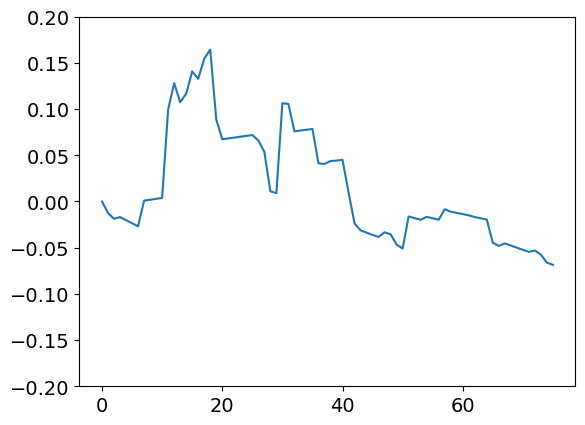

In [51]:
plt.plot(FF.get('sm')[0,:]) # local mean
# plt.xlim(0, 6)  # 设置x轴刻度范围为0到6
plt.ylim(-0.2, 0.2) # 设置y轴刻度范围为0到12

(-0.03, 0.03)

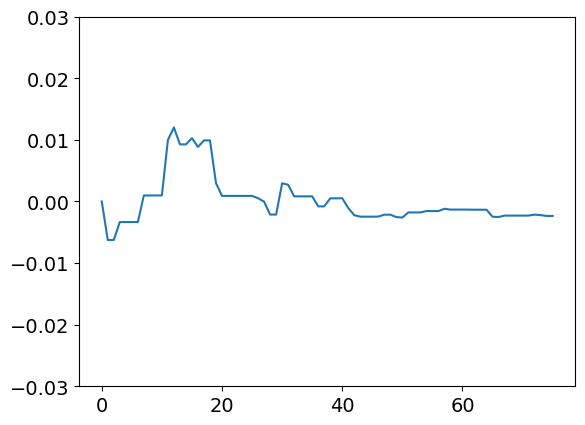

In [52]:
plt.plot(FF.get('sm')[1,:]) # local trend
plt.ylim(-0.03, 0.03) # 设置y轴刻度范围为0到12

(-0.6, 0.6)

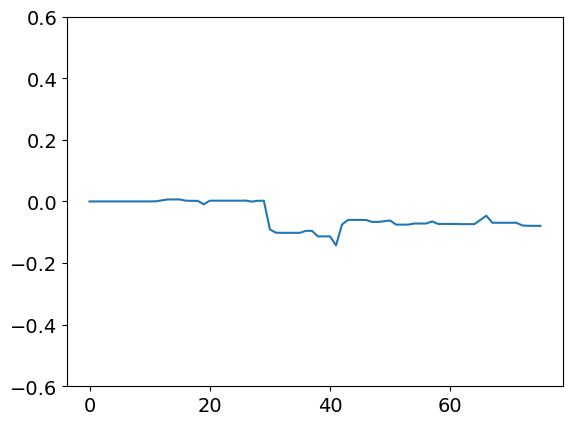

In [53]:
# extract estimates on the coefficient corresponding to lag-1 NDVI
plt.plot(FF.get('sm')[2,:]) # local trend
plt.ylim(-0.6, 0.6) # 设置y轴刻度范围为0到12

(-0.02, 0.025)

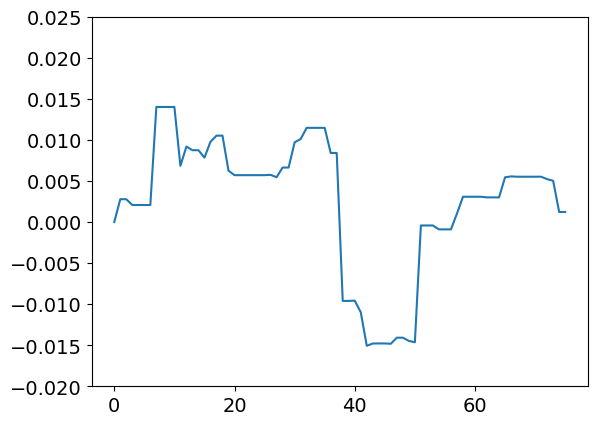

In [54]:
# climate effects
# extract estimates on the coefficient corresponding to lag-1 NDVI
plt.plot(FF.get('sm')[3,:]) # local trend
plt.ylim(-0.02, 0.025) # 设置y轴刻度范围为0到12

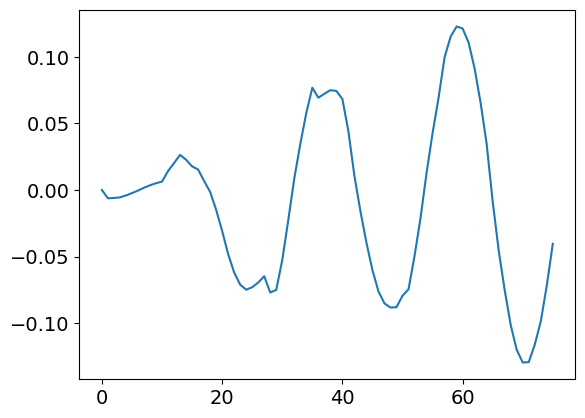

In [56]:
# climate effects
# extract estimates on the coefficient corresponding to lag-1 NDVI
plt.plot(FF.get('sm')[4,:]) # local trend
# plt.ylim(-0.02, 0.025) # 设置y轴刻度范围为0到12